Modul 2: Verschiedene Fit Funktionen / Neue Library lmfit für die Laufzeit

In [2]:
import numpy as np
from lmfit import Model
from scipy.optimize import curve_fit
from os.path import normpath, dirname
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import pandas as pd
import json
import git
import matplotlib.pyplot as plt

In [22]:
label_size = 22
plt.rcParams.update(
    {
        "font.size": label_size,
        "legend.title_fontsize": 22,
        "legend.fontsize": 22,
        "axes.labelsize": label_size,
        "xtick.labelsize": label_size,
        "ytick.labelsize": label_size,
        "axes.labelpad": 4,
        "lines.markersize": 13,
        "lines.linewidth": 2,
    }
)

# This will bind the paths from localSettings.json to objects in a class named paths
# usage: paths.<name>
class JSONObject:
    def __init__(self, dict):
        vars(self).update(dict)
def get_header(filename):
    with open(filename, "r") as f:
        for line in f:
            if line.startswith("#"):
                header = line
            else:
                break  # stop when there are no more #

        header = header[1:].strip().split()
    return header


def na(array):
    return np.array(array)


def quadratic(x, a):
    return a * x ** 2

def quadratic_exp(x, a, b, c):
    y = a * x ** 2 + np.exp(b*x) - c
    return y

def func_potenz_2_4 (x, a, b):
    y = a * x ** 2 + b * x **4
    return y

def polynomiell(x, a, b):
    y = a*x + b*x**2
    # a * x + b * x ** 2
    return y

def polynomiell_error(x, a, b, D_a, D_b):
    y = np.abs(x*D_a) + np.abs(2*b*x*D_b)
    return y

def polynomiell_exp(x, a, b, c):
    y = a*x + b*x**2 + np.exp(c*x)
    # a * x + b * x ** 2 + c*e^(d*x)
    return y

def fit_exp(x, a, b, c):
    return np.exp(b*(x-c))

def polynomiell_exp_error(x, a, b, c, D_a, D_b, D_c):
    y = np.abs(x*D_a) + np.abs(2*b*x*D_b) + np.abs(c*np.exp(c*x)*D_c)
    return y

def exponential(x, a, b, c):
    y = a * np.exp(b * x) + c
    return y


def fehler_quadrat(N_model, N):
    sum_fehler2 = 0
    for i in np.arange(len(N)):
        sum_fehler2 = (N_model[i] - N[i]) ** 2
    return sum_fehler2
    # return np.sum(((N_model-N)**2)/N)


def RMSE(N_model, N):
    sum_fehler2 = 0
    for i in np.arange(len(N)):
        sum_fehler2 = (N_model[i] - N[i]) ** 2
    return np.sqrt(sum_fehler2 / len(N))
    
def round_to_n(data, n=1):
    if n != 1:
        return [round(x, -int(floor(log10(x))) + (n - 1)) for x in data]
    else:
        return [round(x, -int(floor(log10(x)))) for x in data]

# returns data and error rounded to significance of error
def round_to_reference(data, ref, n):
    ref = round_to_n(ref, n)
    return ([round(x, -int(floor(log10(y))) + (n - 1)) for (x,y) in zip(data, ref)], ref)

rtr = round_to_reference


# For PC in university, if conda does not want to install a package, do it by hand
# conda install -n myEnv --use-local myPackageFromAnaconda.tar.bz2
# https://github.com/conda/conda/issues/7245

# Force install for pip
# /bin/python3 -m pip install ipykernel -U --user --force-reinstall
# /bin/python3.6 -m pip install numpy -U --user


# Root Directory of Repository
repo = git.Repo(".", search_parent_directories=True).working_dir
with open(normpath(repo + "/localSettings.json"), "r") as f:
    path_data = f.read()
paths = json.loads(path_data, object_hook=JSONObject)

def fit_function_N (N, x_c, a, b):
    return np.array(x_c + a*N**(-b))

def fit_function_N_err (N, x_c, a, b, D_x_c, D_a, D_b):
    return np.array(D_x_c + N**(-b)*D_a+np.log(N)*a/(N**b)*D_b)

def compute_residual_and_error (fit_function, fit_function_error, data_x, data_y, args_fit, args_err):
    fit = fit_function(data_x, *args_fit)
    fit_error = fit_function_error(data_x, *args_fit, *args_err)
    residuals = data_y - fit
    residuals_err_lower = np.abs(data_y - (fit - fit_error))
    residuals_err_upper = np.abs(data_y - (fit + fit_error))
    residuals_err = np.array([residuals_err_lower, residuals_err_upper])
    return (residuals, residuals_err)

def compute_residual_and_diff_var (fit_function, data_x, data_y, data_y_error, args_fit):
    fit = fit_function(data_x, *args_fit)
    residuals = data_y - fit
    residuals_err_upper = np.abs((data_y + data_y_error) - fit)
    residuals_err_lower = np.abs((data_y - data_y_error) - fit)
    residuals_err = np.array([data_y_error, data_y_error])
    return (residuals, residuals_err)

# Fertige Abb

Polynomieller Fit

[[Model]]
    Model(polynomiell)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 11
    # variables        = 2
    chi-square         = 12.6925884
    reduced chi-square = 1.41028760
    Akaike info crit   = 5.57435253
    Bayesian info crit = 6.37014308
[[Variables]]
    a: -0.02007664 +/- 0.00410022 (20.42%) (init = 1)
    b:  3.5499e-04 +/- 7.8512e-06 (2.21%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) = -0.948


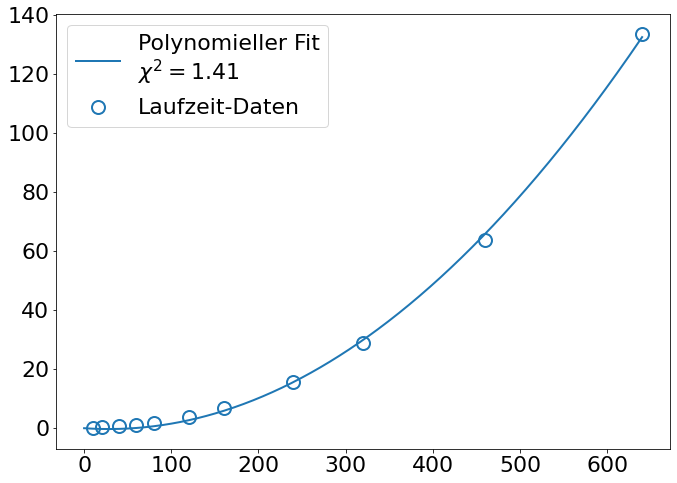

In [4]:
N = np.array([10, 20, 40, 60, 80, 120, 160, 240, 320, 460, 640])
N_all = np.linspace(0,640,641)
time = np.array([0.126, 0.263, 0.618, 1.162, 1.881, 3.937, 6.851, 15.627, 28.888, 60+3.871, 120+13.718])

amodel = Model(polynomiell)
params = amodel.make_params(a=1, b=1)
result = amodel.fit(time, params, x=N)
print(result.fit_report())

fig, ax = plt.subplots(figsize=(11,8))
ax.errorbar(N, time, label="Laufzeit-Daten", c="C0", fmt="o", fillstyle="none", markeredgewidth=2)
ax.plot(N_all, result.eval(result.params, x=N_all), label=f'Polynomieller Fit\n$\chi^2={{{result.redchi:.2f}}}$')

ax.legend()
plt.savefig('Abb/Mod2_Laufzeit_Polynomiell.png')
plt.show()

Residuen

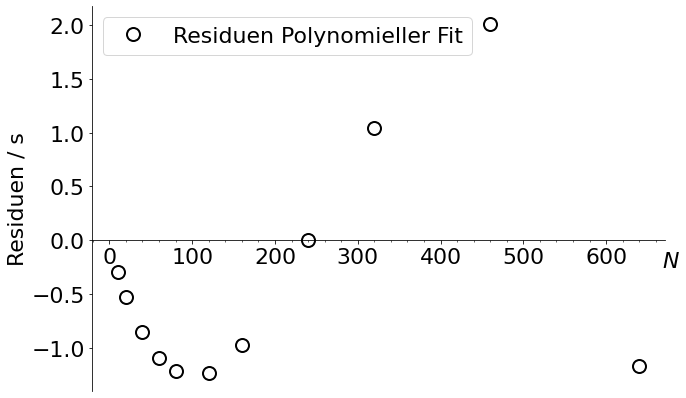

In [5]:
fig, ax = plt.subplots(figsize=(10,6), tight_layout=True)
ax.errorbar(N, result.residual, label=f'Residuen Polynomieller Fit', c="k", fmt="o", ecolor="k", fillstyle="none", markeredgewidth=2)
plt.xlabel('$N$', horizontalalignment='right', verticalalignment='bottom', x=1.025)
ax.set_ylabel('Residuen / s')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.legend()
plt.savefig(f'Abb/Mod2_Residuen_Laufzeit_Polynomiell.png')

Poly und Exp Fit

[[Model]]
    Model(polynomiell_exp)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3221
    # data points      = 11
    # variables        = 4
    chi-square         = 0.40465818
    reduced chi-square = 0.05780831
    Akaike info crit   = -28.3286862
    Bayesian info crit = -26.7371051
[[Variables]]
    a: -0.01358800 +/- 0.00232539 (17.11%) (init = 1)
    b:  2.8142e-04 +/- 7.2415e-06 (2.57%) (init = 1)
    c:  0.00519206 +/- 1.0026e-04 (1.93%) (init = 1)
    d:  0.56026849 +/- 0.16163342 (28.85%) (init = -1)
[[Correlations]] (unreported correlations are < 0.100)
    C(b, c) = -0.957
    C(a, b) = -0.945
    C(a, c) = 0.821
    C(a, d) = 0.817
    C(b, d) = -0.675
    C(c, d) = 0.537


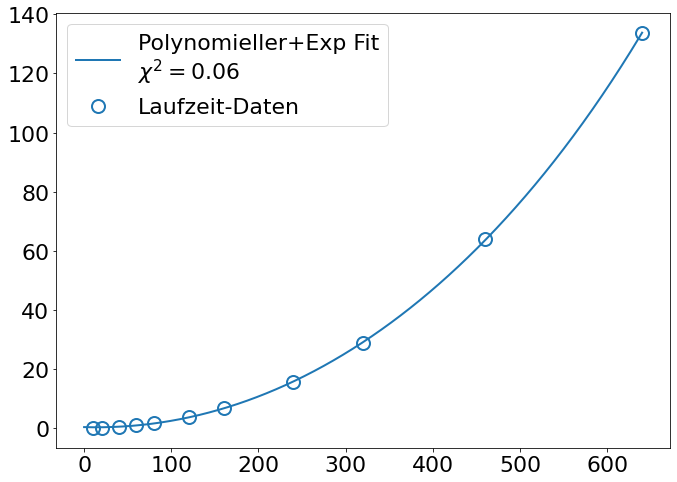

In [23]:
amodel = Model(polynomiell_exp)
params = amodel.make_params(a=1, b=1, c=1)
result = amodel.fit(time, params, x=N)
print(result.fit_report())

fig, ax = plt.subplots(figsize=(11,8))
ax.errorbar(N, time, label="Laufzeit-Daten", c="C0", fmt="o", fillstyle="none", markeredgewidth=2)
ax.plot(N_all, result.eval(result.params, x=N_all), label=f'Polynomieller+Exp Fit\n$\chi^2={{{result.redchi:.2f}}}$')

ax.legend()
plt.savefig('Abb/Mod2_Laufzeit_Polynomiell_Exp.png')
plt.show()

Residuen

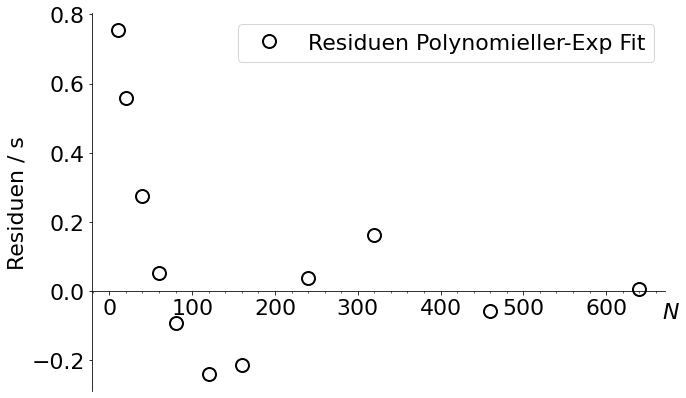

In [7]:
fig, ax = plt.subplots(figsize=(10,6), tight_layout=True)
ax.errorbar(N, result.residual, label=f'Residuen Polynomieller-Exp Fit', c="k", fmt="o", fillstyle="none", markeredgewidth=2)
plt.xlabel('$N$', horizontalalignment='right', verticalalignment='bottom', x=1.025)
ax.set_ylabel('Residuen / s')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.legend()
plt.savefig(f'Abb/Mod2_Residuen_Laufzeit_Polynomiell_Exp.png')

# Andere Fits zum Testen

Quadratisch-Exponentiell

[[Model]]
    Model(quadratic_exp)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2568
    # data points      = 11
    # variables        = 3
    chi-square         = 2.39481047
    reduced chi-square = 0.29935131
    Akaike info crit   = -10.7705030
    Bayesian info crit = -9.57681717
[[Variables]]
    a:  2.4234e-04 +/- 4.9945e-06 (2.06%) (init = 1)
    b:  0.00559521 +/- 9.3175e-05 (1.67%) (init = 1)
    c:  1.33124521 +/- 0.21259298 (15.97%) (init = -1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) = -0.963
    C(a, c) = 0.523
    C(b, c) = -0.408


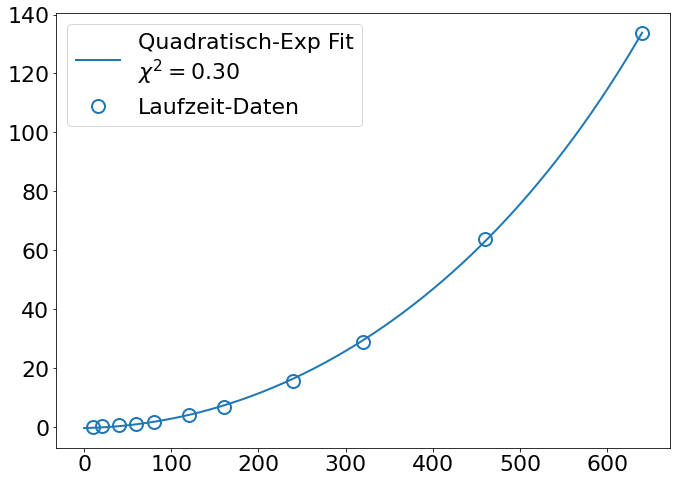

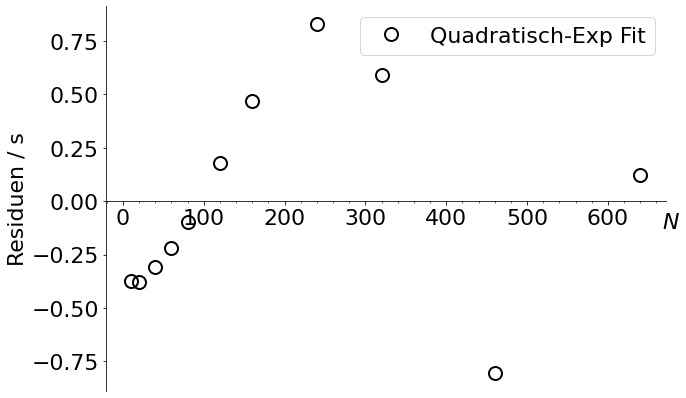

In [21]:
amodel = Model(quadratic_exp)
params = amodel.make_params(a=1, b=1, c=-1)
result = amodel.fit(time, params, x=N)
print(result.fit_report())

fig, ax = plt.subplots(figsize=(11,8))
ax.errorbar(N, time, label="Laufzeit-Daten", c="C0", fmt="o", fillstyle="none", markeredgewidth=2)
ax.plot(N_all, result.eval(result.params, x=N_all), label=f'Quadratisch-Exp Fit\n$\chi^2={{{result.redchi:.2f}}}$')

ax.legend()
plt.savefig('Abb/Mod2_Laufzeit_Quadratisch-Exp.png')
plt.show()

fig, ax = plt.subplots(figsize=(10,6), tight_layout=True)
ax.errorbar(N, result.residual, label=f'Quadratisch-Exp Fit', c="k", fmt="o", fillstyle="none", markeredgewidth=2)
plt.xlabel('$N$', horizontalalignment='right', verticalalignment='bottom', x=1.025)
ax.set_ylabel('Residuen / s')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.legend()
plt.savefig(f'Abb/Mod2_Residuen_Laufzeit_Quadratisch-Exp.png')

Exponential

[[Model]]
    Model(fit_exp)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2529
    # data points      = 11
    # variables        = 3
    chi-square         = 380218.720
    reduced chi-square = 47527.3400
    Akaike info crit   = 120.956673
    Bayesian info crit = 122.150359
##  Warning: uncertainties could not be estimated:
    a:  at initial value
[[Variables]]
    a:  1.00000000 (init = 1)
    b:  0.01576663 (init = 1)
    c:  220.178102 (init = 1)


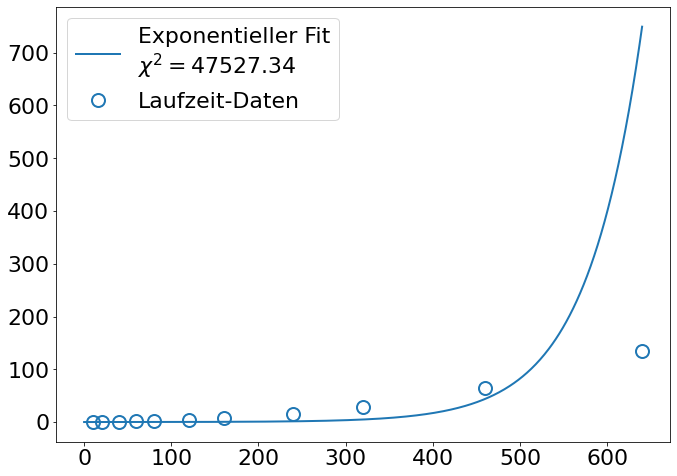

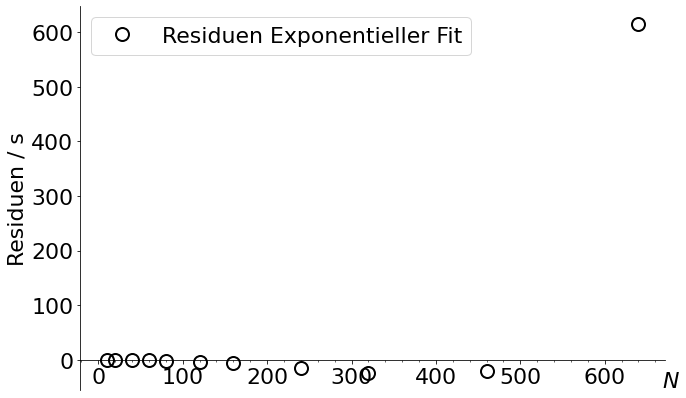

In [9]:
amodel = Model(fit_exp)
params = amodel.make_params(a=1, b=1, c=1)
result = amodel.fit(time, params, x=N)
print(result.fit_report())

fig, ax = plt.subplots(figsize=(11,8))
ax.errorbar(N, time, label="Laufzeit-Daten", c="C0", fmt="o", fillstyle="none", markeredgewidth=2)
ax.plot(N_all, result.eval(result.params, x=N_all), label=f'Exponentieller Fit\n$\chi^2={{{result.redchi:.2f}}}$')

ax.legend()
plt.savefig('Abb/Mod2_Laufzeit_Quadratic.png')
plt.show()

fig, ax = plt.subplots(figsize=(10,6), tight_layout=True)
ax.errorbar(N, result.residual, label=f'Residuen Exponentieller Fit', c="k", fmt="o", fillstyle="none", markeredgewidth=2)
plt.xlabel('$N$', horizontalalignment='right', verticalalignment='bottom', x=1.025)
ax.set_ylabel('Residuen / s')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.legend()
plt.savefig(f'Abb/Mod2_Residuen_Laufzeit_Exponentieller.png')

quadratisch

[[Model]]
    Model(quadratic)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 5
    # data points      = 11
    # variables        = 1
    chi-square         = 46.5050077
    reduced chi-square = 4.65050077
    Akaike info crit   = 17.8583120
    Bayesian info crit = 18.2562073
[[Variables]]
    a:  3.1854e-04 +/- 4.5235e-06 (1.42%) (init = 1)


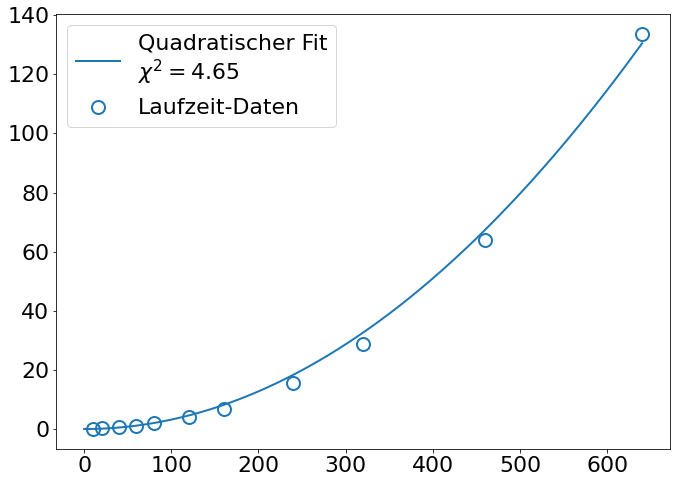

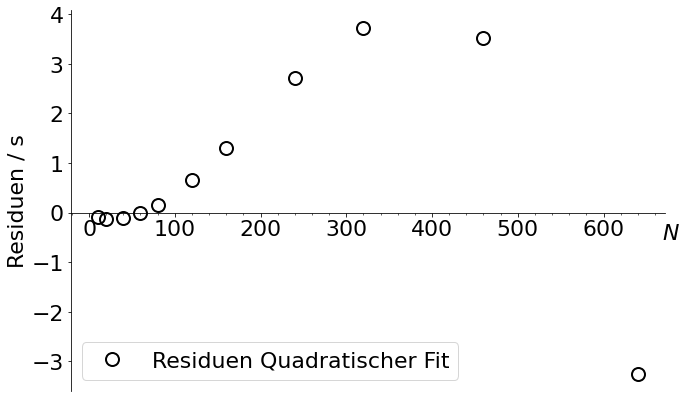

In [10]:
amodel = Model(quadratic)
params = amodel.make_params(a=1)
result = amodel.fit(time, params, x=N)
print(result.fit_report())

fig, ax = plt.subplots(figsize=(11,8))
ax.errorbar(N, time, label="Laufzeit-Daten", c="C0", fmt="o", fillstyle="none", markeredgewidth=2)
ax.plot(N_all, result.eval(result.params, x=N_all), label=f'Quadratischer Fit\n$\chi^2={{{result.redchi:.2f}}}$')

ax.legend()
plt.savefig('Abb/Mod2_Laufzeit_Quadratic.png')
plt.show()

fig, ax = plt.subplots(figsize=(10,6), tight_layout=True)
ax.errorbar(N, result.residual, label=f'Residuen Quadratischer Fit', c="k", fmt="o", fillstyle="none", markeredgewidth=2)
plt.xlabel('$N$', horizontalalignment='right', verticalalignment='bottom', x=1.025)
ax.set_ylabel('Residuen / s')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.legend()
plt.savefig(f'Abb/Mod2_Residuen_Laufzeit_Quadratic.png')

Potenz 4

[[Model]]
    Model(func_potenz_2_4)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 11
    # variables        = 2
    chi-square         = 0.62574128
    reduced chi-square = 0.06952681
    Akaike info crit   = -27.5338492
    Bayesian info crit = -26.7380587
[[Variables]]
    a:  2.7096e-04 +/- 1.9328e-06 (0.71%) (init = 1)
    b:  1.3604e-10 +/- 5.2958e-12 (3.89%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) = -0.958


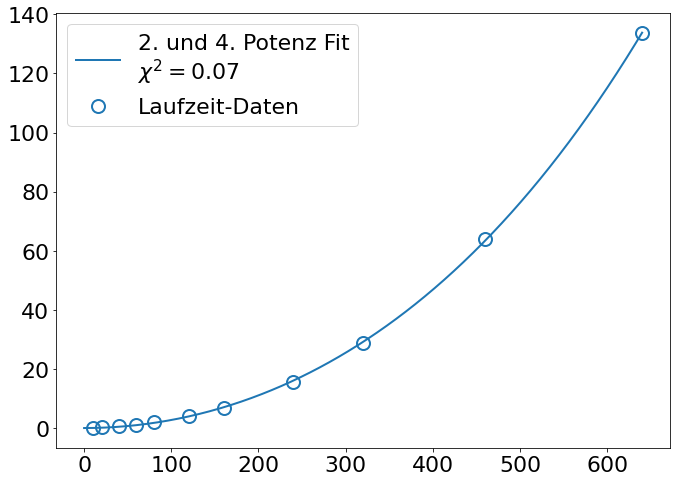

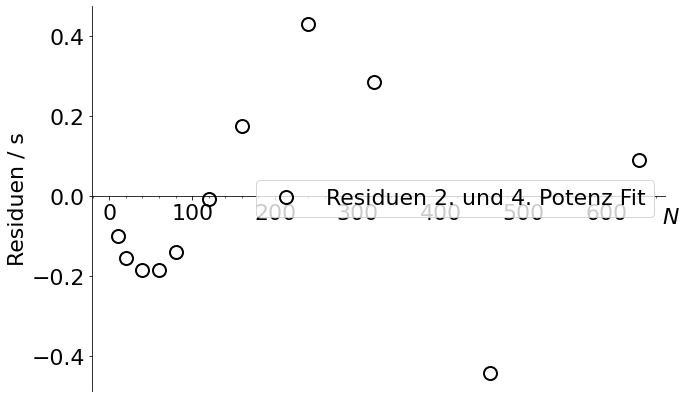

In [11]:
amodel = Model(func_potenz_2_4)
params = amodel.make_params(a=1, b=1)
result = amodel.fit(time, params, x=N)
print(result.fit_report())

fig, ax = plt.subplots(figsize=(11,8))
ax.errorbar(N, time, label="Laufzeit-Daten", c="C0", fmt="o", fillstyle="none", markeredgewidth=2)
ax.plot(N_all, result.eval(result.params, x=N_all), label=f'2. und 4. Potenz Fit\n$\chi^2={{{result.redchi:.2f}}}$')

ax.legend()
plt.savefig('Abb/Mod2_Laufzeit_Quadratic.png')
plt.show()

fig, ax = plt.subplots(figsize=(10,6), tight_layout=True)
ax.errorbar(N, result.residual, label=f'Residuen 2. und 4. Potenz Fit', c="k", fmt="o", fillstyle="none", markeredgewidth=2)
plt.xlabel('$N$', horizontalalignment='right', verticalalignment='bottom', x=1.025)
ax.set_ylabel('Residuen / s')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.legend()
plt.savefig(f'Abb/Mod2_Residuen_Laufzeit_Potenz_2_4.png')

Polyfit: Scipy-Curvefit

Manual input, Polyn.: -2.01e-02 +- 4.1e-03, 3.55e-04 +- 7.9e-06


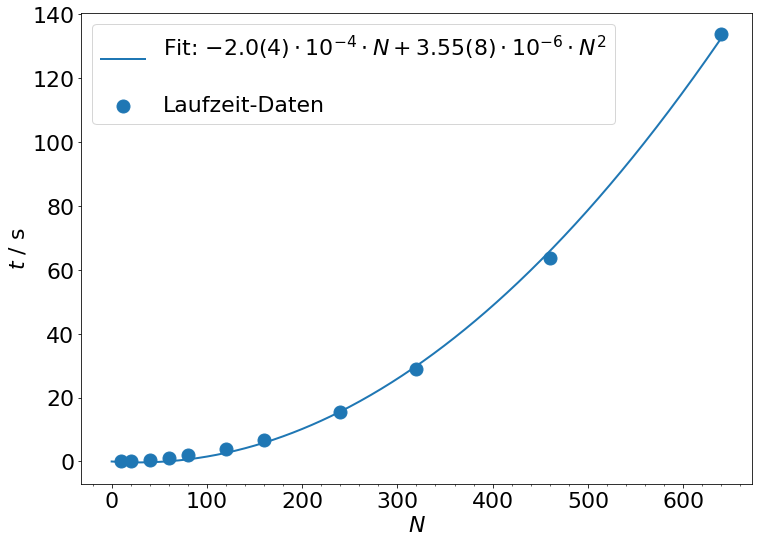

In [12]:
N = np.array([10, 20, 40, 60, 80, 120, 160, 240, 320, 460, 640])
N_all = np.linspace(0,640,641)
time = np.array([0.126, 0.263, 0.618, 1.162, 1.881, 3.937, 6.851, 15.627, 28.888, 60+3.871, 120+13.718])
path = normpath(paths.Modul2+'Aufg3/Laufzeit.dat')
with open(path) as file:
    for line in file.readlines():
        if line[0] == 'u':
            # print(line)
            pass
            
fig, ax = plt.subplots(figsize=(11,8))
ax.scatter(N,time, label="Laufzeit-Daten")
# ax.plot(N,time, ls = "--", alpha=0.8,)

# Fit Polynomiell
parameters, covariance = curve_fit(polynomiell, N, time, p0=[-0.02, 3.55])
std_error = np.sqrt(np.diag(covariance))
fit_y = polynomiell(N_all, parameters[0], parameters[1])

print(f"Manual input, Polyn.: {parameters[0]:.2e} +- {std_error[0]:.1e}, {parameters[1]:.2e} +- {std_error[1]:.1e}")
time_model = polynomiell(np.array(N), parameters[0], parameters[1])
ax.plot(N_all, fit_y, label="Fit: $-2.0(4)\cdot 10^{-4}\cdot N + 3.55(8)\cdot10^{-6}\cdot N^2$\n")

ax.set_xlabel("$N$")
ax.set_ylabel("$t$ / s")
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.legend()
plt.tight_layout()
# plt.savefig('Abb/Mod2_Laufzeit')

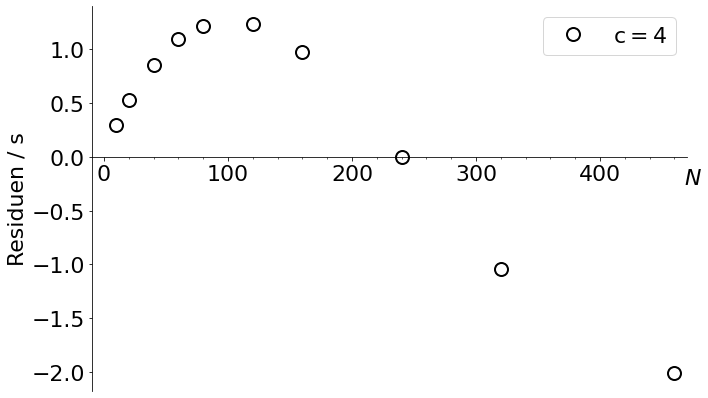

In [13]:
c=4
fig, ax = plt.subplots(figsize=(10,6), tight_layout=True)
(residuals, residuals_err) = compute_residual_and_error(polynomiell, polynomiell_error, N, time, parameters, std_error)
ax.errorbar(N, residuals, label=f'c$={c}$', c="k", fmt="o", ecolor="k", elinewidth=2, capsize=6, fillstyle="none", markeredgewidth=2)
plt.xlabel('$N$', horizontalalignment='right', verticalalignment='bottom', x=1.025)
ax.set_ylabel('Residuen / s')
ax.set_xlim(-10,470)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.legend()
# plt.savefig(f'Abb/Mod2_Residual_Laufzeit.png')

[[Model]]
    Model(polynomiell)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 11
    # variables        = 2
    chi-square         = 12.6925884
    reduced chi-square = 1.41028760
    Akaike info crit   = 5.57435253
    Bayesian info crit = 6.37014308
[[Variables]]
    a: -0.02007664 +/- 0.00410022 (20.42%) (init = 1)
    b:  3.5499e-04 +/- 7.8512e-06 (2.21%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) = -0.948


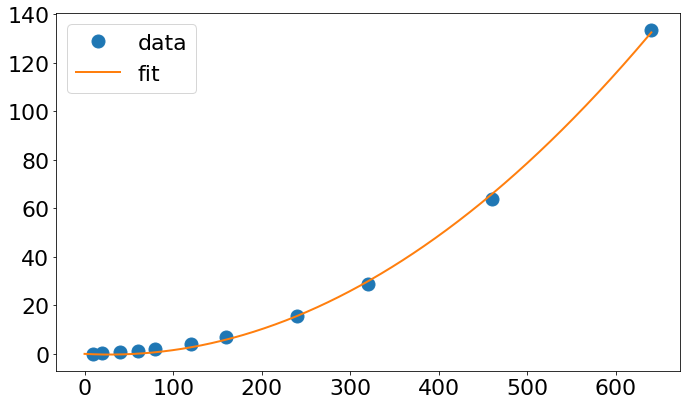

In [14]:
amodel = Model(polynomiell)
params = amodel.make_params(a=1, b=1)
result = amodel.fit(time, params, x=N)
print(result.fit_report())

fig, ax = plt.subplots(figsize=(10,6), tight_layout=True)
ax.plot(N, time, 'o', label='data')
ax.plot(N_all, result.eval(result.params, x=N_all), label='fit')
ax.legend()
plt.show()

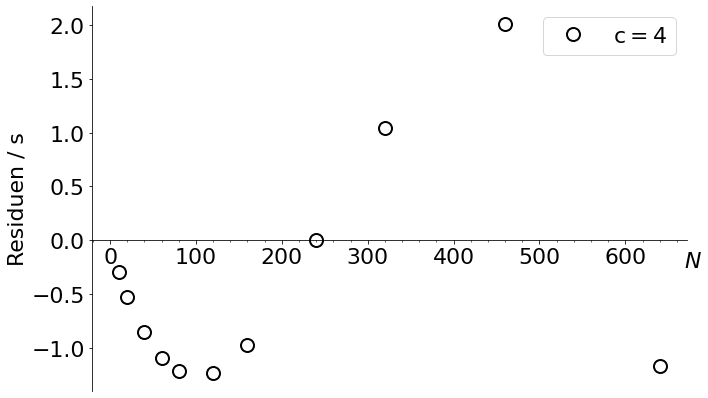

In [15]:
fig, ax = plt.subplots(figsize=(10,6), tight_layout=True)
ax.errorbar(N, result.residual, label=f'c$={c}$', c="k", fmt="o", ecolor="k", elinewidth=2, capsize=6, fillstyle="none", markeredgewidth=2)
plt.xlabel('$N$', horizontalalignment='right', verticalalignment='bottom', x=1.025)
ax.set_ylabel('Residuen / s')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.legend()
# plt.savefig(f'Abb/Mod2_Residual_Laufzeit.png')

[[Model]]
    Model(polynomiell_exp)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 265
    # data points      = 11
    # variables        = 3
    chi-square         = 1.09926942
    reduced chi-square = 0.13740868
    Akaike info crit   = -19.3357443
    Bayesian info crit = -18.1420585
[[Variables]]
    a: -0.02016584 +/- 0.00206460 (10.24%) (init = 0.1)
    b:  2.9851e-04 +/- 8.4660e-06 (2.84%) (init = 3.5)
    c:  0.00498887 +/- 1.5492e-04 (3.11%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(b, c) = -0.957
    C(a, b) = -0.921
    C(a, c) = 0.785


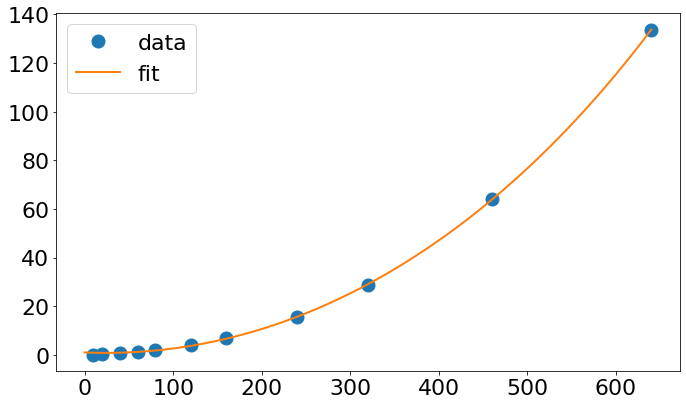

In [16]:
amodel = Model(polynomiell_exp)
params = amodel.make_params(a=0.1, b=3.5, c=0.1)
result = amodel.fit(time, params, x=N)
print(result.fit_report())

fig, ax = plt.subplots(figsize=(10,6), tight_layout=True)
ax.plot(N, time, 'o', label='data')
ax.plot(N_all, result.eval(result.params, x=N_all), label='fit')
ax.legend()
plt.show()

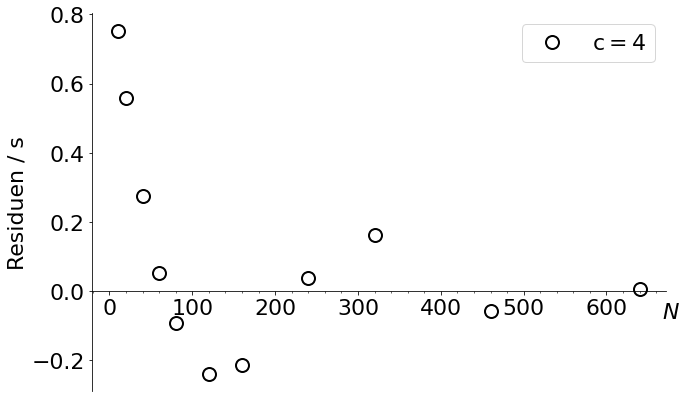

In [17]:
fig, ax = plt.subplots(figsize=(10,6), tight_layout=True)
ax.errorbar(N, result.residual, label=f'c$={c}$', c="k", fmt="o", ecolor="k", elinewidth=2, capsize=6, fillstyle="none", markeredgewidth=2)
plt.xlabel('$N$', horizontalalignment='right', verticalalignment='bottom', x=1.025)
ax.set_ylabel('Residuen / s')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.legend()
# plt.savefig(f'Abb/Mod2_Residual_Laufzeit.png')


Fit geht auch per Polyfit, aber nicht so schön und einfach

Sum-diff-squared: 2.7887875711057518e-05


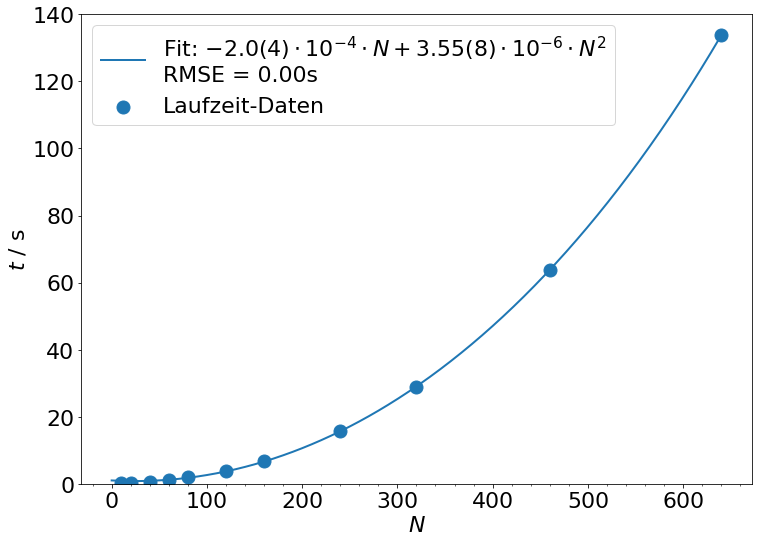

In [18]:
fig, ax = plt.subplots(figsize=(11,8))
ax.scatter(N,time, label="Laufzeit-Daten")
# ax.plot(N,time, ls = "--", alpha=0.8,)

# Fit Polynomiell-Exponentiell
parameters, covariance = curve_fit(polynomiell_exp, N, time, p0=[-0.02, 3.55, 0.005])
std_error = np.sqrt(np.diag(covariance))
fit_y = polynomiell_exp(N_all, *parameters)

# print(f"Manual input, Polyn.: {parameters[0]:.2e} +- {std_error[0]:.1e}, {parameters[1]:.2e} +- {std_error[1]:.1e}")
time_model = polynomiell_exp(np.array(N), *parameters)
print(f"Sum-diff-squared: {fehler_quadrat(time_model, time)}")
ax.plot(N_all, fit_y, label="Fit: $-2.0(4)\cdot 10^{-4}\cdot N + 3.55(8)\cdot10^{-6}\cdot N^2$\n"+f"RMSE = {RMSE(time_model, time):.2f}s")

ax.set_xlabel("$N$")
ax.set_ylabel("$t$ / s")
ax.set_ylim (0,140)
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.legend()
plt.tight_layout()
# plt.savefig('Abb/Mod2_Laufzeit')

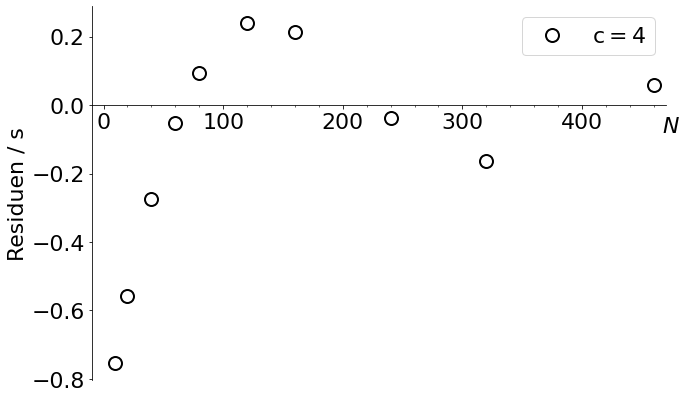

In [19]:
fig, ax = plt.subplots(figsize=(10,6), tight_layout=True)
(residuals, residuals_err) = compute_residual_and_error(polynomiell_exp, polynomiell_exp_error, N, time, parameters, std_error)
ax.errorbar(N, residuals, label=f'c$={c}$', c="k", fmt="o", ecolor="k", elinewidth=2, capsize=6, fillstyle="none", markeredgewidth=2)
plt.xlabel('$N$', horizontalalignment='right', verticalalignment='bottom', x=1.025)
ax.set_ylabel('Residuen / s')
ax.set_xlim(-10,470)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.legend()
# plt.savefig(f'Abb/Mod2_Residual_Laufzeit.png')
